# NBLASTING FlyWire neurons against Janelia hemibrain
Let's say you have traced a couple neurons in FlyWire and want to find the same neurons in the Janelia hemibrain dataset. You could try searching manually or you just use NBLAST to find potential matches for you!

To run below code you will needt these libraries:

1. `fafbseg` (duh)
2. [navis](https://navis.readthedocs.io/en/latest/) (version >= 0.5.2)
3. [flybrains](https://github.com/schlegelp/navis-flybrains) (version >=0.1.4) including the optional Saalfeld transforms (see docs)

Let's jump right in!

In [4]:
import navis
import flybrains

from fafbseg import flywire

`navis` wraps `neuprint-python` and adds convenience functions which we will use later on to visualize potential matches.

A quick outline of what we will do now:

1. Load a couple FlyWire neurons 
2. Turn the neurons into dotprops for NBLASTing
3. Transform the dotprops to the `JRC2018F` template space
4. Mirror left-hand-side FlyWire dotprops to the right
5. Prune the FlyWire dotprops to the approximate hemibrain volume
6. NBLAST against ~26k hemibrain neurons
7. Inspect potential matches

OK, first to get some FlyWire neurons. For demonstration purposes, I will use some olfactory projection neurons from the left and the right since we know the ground truth for those:

In [6]:
# Root IDs of three PNs
root_ids = [720575940613852614, 720575940626542891, 720575940621770759]

# Fetch the meshes
fw = flywire.get_mesh_neuron(root_ids)

Next we will transform them to dotprops for NBLASTing. This also simplifies them from hundreds of thousands of vertices to a couple thousand points which makes all subsequent steps much faster. Note that we are resampling them to approximately 1 point per micron. This is important because the hemibrain dotprops will have the same sampling and we should try to keep things equal.

In [55]:
fw_dps = navis.make_dotprops(fw, resample=1000, k=5)

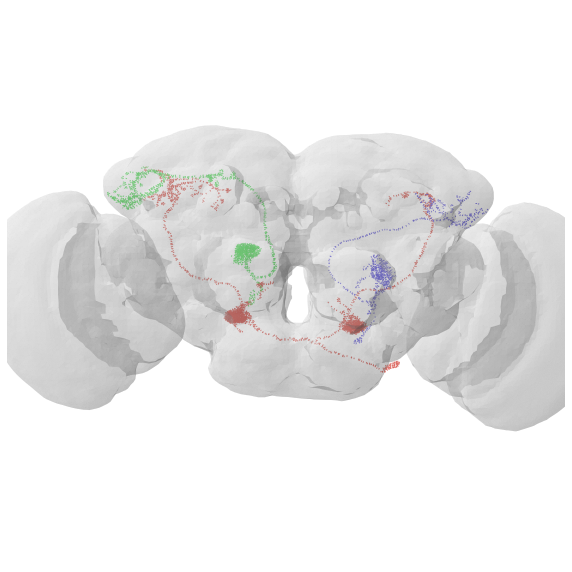

In [176]:
# A quick visualization
fig, ax = navis.plot2d([fw_dps, flybrains.FAFB14], dps_scale_vec=1000, lw=1.5, figsize=(10, 12))
ax.azim = ax.elev = -90
ax.dist = 5

- the green PN should be entirely contained in the hemibrain volume
- the red bilateral PN will be truncated but we should still be able to find a match
- the blue left-hand-side PN we will need to mirror to the right

Next: transform the dotprops to JRC2018F brain space. This template brain is an average of several brains and as such is symmetric which means we can mirror things really easily. It is also in microns! Both the template brain as well as the transforms to/from it are provided by the Saalfeld lab (Janelia), in particular John Bogovic.

In [56]:
fw_dps_2018f = navis.xform_brain(fw_dps, source='FLYWIRE', target='JRC2018F')

INFO  : Pre-caching deformation field(s) for transforms... (navis)


Transform path: FLYWIRE -> FLYWIREraw -> FAFB14raw -> FAFB14 -> FAFB14um -> JRC2018F


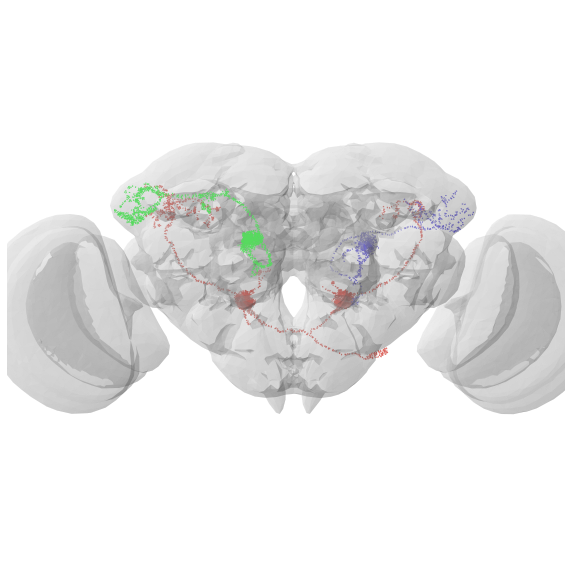

In [183]:
# Quick sanity check
fig, ax = navis.plot2d([fw_dps_2018f, flybrains.JRC2018F], dps_scale_vec=1, lw=1.5, figsize=(10, 12))
ax.azim = ax.elev = -90
ax.dist = 5

Now mirror `720575940621770759` to the right hand side:

In [105]:
mirrored = navis.mirror_brain(fw_dps_2018f.idx[720575940621770759], template='JRC2018F')

# There is an issue with navis 0.5.2 and which causes the points being upcast from float32 to float64
# That's usually not a problem except here because the pykdtree library for NBLAST might complain 
# This will be fixed in future releases of navis and I will update the tutorial when that has happend
mirrored.points = mirrored.points.astype('float32')

# Combine
fw_dps_2018f_right = fw_dps_2018f.idx[[720575940613852614, 720575940626542891]] + mirrored

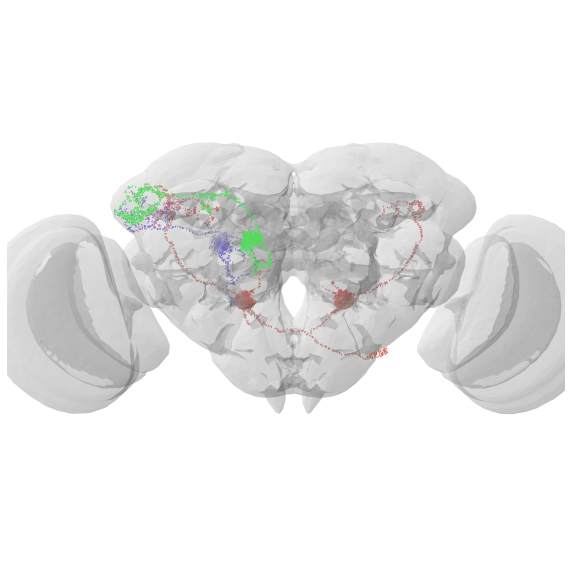

In [182]:
# Final sanity check
fig, ax = navis.plot2d([fw_dps_2018f_right, flybrains.JRC2018F], dps_scale_vec=1, lw=1.5, figsize=(10, 12))
ax.azim = ax.elev = -90
ax.dist = 5

Now prune the neurons to the approximate bounding box of the hemibrain. 

In [62]:
bbox = flybrains.JRCFIB2018Fraw.bbox

# Ignore the warning about too many points being outside the volume
bbox_2018f = navis.xform_brain(bbox, source='JRCFIB2018Fraw', target='JRC2018F')

Transform path: JRCFIB2018Fraw -> JRCFIB2018F -> JRCFIB2018Fum -> JRC2018F


In [107]:
fw_dps_2018f_final = navis.in_volume(fw_dps_2018f_right, bbox_2018f)

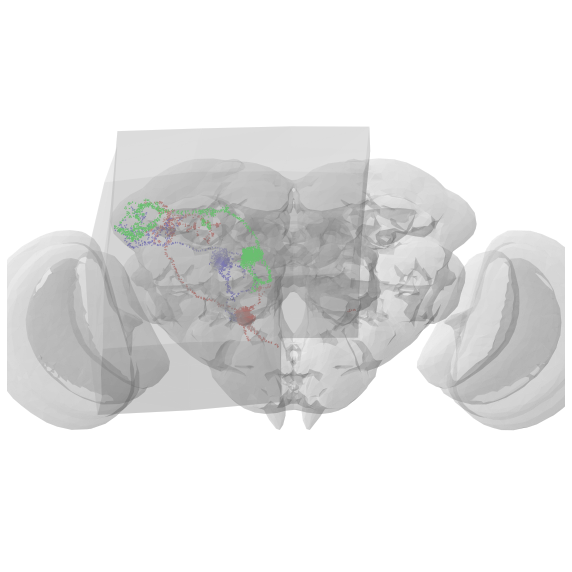

In [181]:
# Final final sanity check
fig, ax = navis.plot2d([fw_dps_2018f_final, bbox_2018f, flybrains.JRC2018F], dps_scale_vec=1, lw=1.5, figsize=(10, 12))
ax.azim = ax.elev = -90
ax.dist = 5

OK that looks good! For what it's worth: we're doing these visualization only for illustrative purposes but I do recommend you spot check your data as you process it.

Next we need to get dotprops for all hemibrain neurons. If you want to do this yourself you would need to:

1. Download a hemibrain skeleton dump or individual skeletons from neuprint 
2. Generate dotprops from the skeletons (don't forget to resample to 1 micron!)
3. Transform to JRC2018U template space

Lucky for you, I already did that and you can download the pickled data from my Google drive:

https://drive.google.com/file/d/1pcPpiDdG_VxnY74ttXVOLDbhDlkIq3Ad/view?usp=sharing (~1.3Gb)


In [114]:
# Load the data 
import pickle 
with open('hemibrain_dotprops_jrc2018f.pkl', 'rb') as f:
    hemi_dps_2018f = pickle.load(f)
    
print(f'We have dotprops for {len(hemi_dps_2018f)} hemibrain neurons')

We have dotprops for 25607 hemibrain neurons


Now we are all set for starting the NBLAST. Here, we will be using `navis.nblast_smart`. This function works by first running a pre-NBLAST on highly simplified dotprops and then running a full NBLAST only for interesting (i.e. high scoring) pairs of neurons. This is much faster and perfectly sufficient if you are only trying to find good matches. For quantitative analyses you should go for a normal full NBLAST with `navis.nblast`!

In [ ]:
# Check out the parameters
# - scores are normalized such that 1 is a perfect match
# - we get the 'mean' of the forward and reverse scores 
# - the full NBLAST will be run on the top 10 target of the pre-NBLAST for each FlyWire neuron
scores = navis.nblast_smart(fw_dps_2018f_final, hemi_dps_2018f, scores='mean', criterion='N', t=10, normalized=True)

In [169]:
# The index/columns are the FlyWire root and hemibrain body IDs, respectively
scores

,730562993,1038079690,706948318,297938585,5813063224,1751943911,1624418395,1686190133,5812997194,5813021017,...,1817799390,1793014384,575768294,324790113,2069647778,387507495,328713871,1473695252,1042651606,390245740
720575940613852614,-0.317906,-0.824387,-0.689619,-0.646354,-0.570998,-0.713661,-0.822287,-0.770065,-0.880665,-0.494713,...,-0.826107,-0.685051,-0.502179,-0.583609,0.255378,-0.384741,-0.881489,-0.739343,-0.050083,-0.479143
720575940626542891,-0.338047,-0.819632,-0.644048,-0.599290,-0.418029,-0.880746,-0.880055,-0.847185,-0.880046,-0.332676,...,-0.880994,-0.321261,-0.525081,-0.546979,-0.542610,-0.330692,-0.845514,-0.751669,-0.546660,-0.300891
720575940621770759,-0.284522,-0.863342,-0.641244,-0.851290,-0.732890,-0.881525,-0.850988,-0.780079,-0.881242,-0.470615,...,-0.882160,-0.340289,-0.456179,-0.809773,-0.214426,-0.630141,-0.880620,-0.643453,-0.394046,-0.445954


Next we will get the, say, top 3 matches for each of our query neurons:

In [157]:
import numpy as np
import pandas as pd

def get_top(N=3):
    """Produce matrix with top N matches."""
    # For each row get the order of columns in ascending score
    ix_srt = np.argsort(scores.values, axis=1)[:, ::-1]
    
    # Populate a DataFrame
    df = pd.DataFrame([])
    
    for i in range(N):
        df[f'top_{i+1}'] = scores.columns[ix_srt[:, i]]
        df[f'top_{i+1}_score'] = scores.values[np.arange(scores.shape[0]), ix_srt[:, i]]
        
    df.index = scores.index
        
    return df
    
top_3 = get_top(N=3)
top_3

,top_1,top_1_score,top_2,top_2_score,top_3,top_3_score
720575940613852614,2064165421,0.726949,666818300,0.435697,5813103893,0.391695
720575940626542891,693483018,0.631542,635062078,0.375847,5813056596,0.368527
720575940621770759,733316908,0.675452,886812643,0.518861,754538881,0.395918


It looks like we found reasonably hits for all three PNs. Let's check those out - black is the hemibrain neuron, red is the top hit:

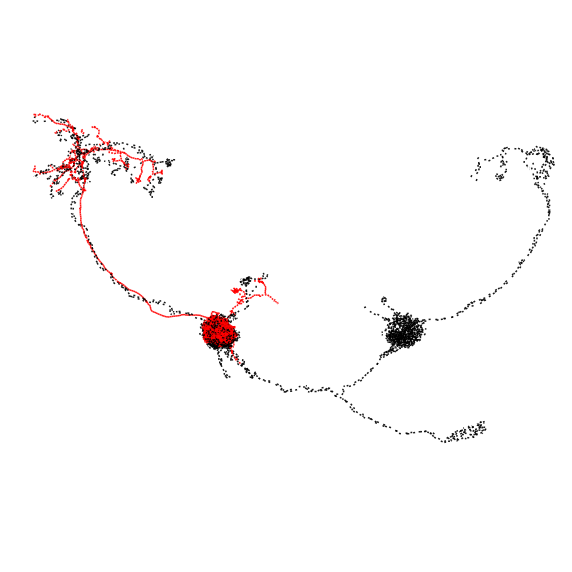

In [178]:
# Final final sanity check
fig, ax = navis.plot2d([fw_dps_2018f_right.idx[720575940613852614],
                        hemi_dps_2018f.idx[2064165421]], figsize=(10, 12),
                       method='3d_complex', lw=1.5, c=['k', 'r'])
ax.azim = ax.elev = -90
ax.dist = 6

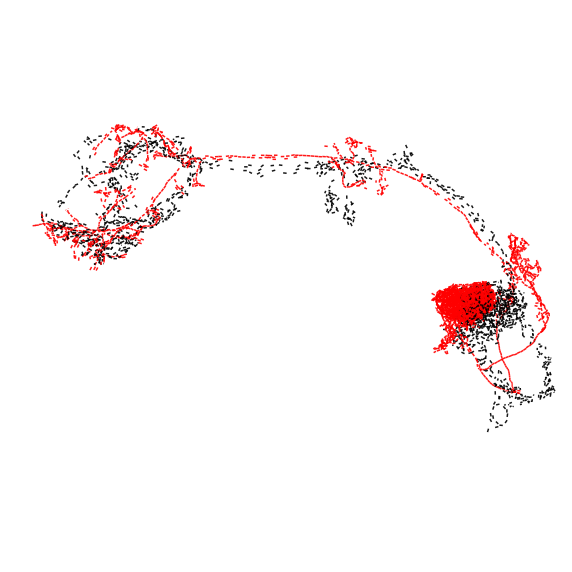

In [179]:
# Final final sanity check
fig, ax = navis.plot2d([fw_dps_2018f_right.idx[720575940626542891],
                        hemi_dps_2018f.idx[693483018]], figsize=(10, 12),
                       method='3d_complex', lw=1.5, c=['k', 'r'],)
ax.azim = ax.elev = -90
ax.dist = 6

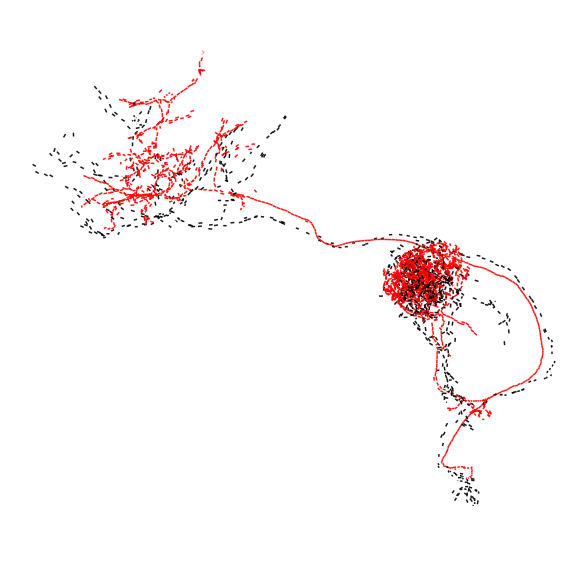

In [180]:
# Final final sanity check
fig, ax = navis.plot2d([fw_dps_2018f_right.idx[720575940621770759],
                        hemi_dps_2018f.idx[733316908]], figsize=(10, 12),
                       method='3d_complex', lw=1.5, c=['k', 'r'])
ax.azim = ax.elev = -90
ax.dist = 6

Based on the dotprops, all matches look decent. Moving forward, you could load the skeletons or meshes from neuprint (see this [tutorial](https://navis.readthedocs.io/en/latest/source/tutorials/neuprint.html)), transform them to a common space with the FlyWire neurons and co-visualize them.

**A few final notes**

1. Here we NBLASTed dotprops from meshes (FlyWire) against dotprops from skeletons (hemibrain). This seems to get the job done but is probably not ideal - you can see the point densities are different.
2. FlyWire meshes are large and downloading them is rather slow. In the future, we might instead use coarse skeletons extracted from the L2 graph (based on an idea by Casey Schneider-Mizell).